In [1]:
import numpy as np
import mxnet as mx
from data_loader import get_iterators
from utils import *


数据分析主要对anchor的W和H进行分类；
SSD的anchor选择是先对size_list[i,i+1]的值进行等比例缩放，size_list[i]到size_list[i+1]的变化作为当前输出层的anchor选择，然后才对ratios的[1,2,.5]三个比例进行长宽比缩放。（原文方法为5个anchor，分别为[i/sqrt(2),i*sqrt(2)],[i+1/sqrt(2),i+1*sqrt(2)]，[i/sqrt(.5),i*sqrt(.5)]，[i+1/sqrt(.5),i+1 * sqrt(.5)],[sqrt(i * (i+1)),sqrt(i * (i+1))]）

In [13]:
data_shape = (3,512,512)
batch_size = 4
std = np.array([58.395, 57.12, 57.375])
rgb_mean = np.array([130.063048, 129.967301, 124.410760]) 
ctx = mx.gpu(0)
resize = data_shape[1:]
rec_prefix = './dataset/data/rec/img_'+str(resize[0])+'_'+str(resize[1])
train_data,valid_data,class_names,num_classes=get_iterators(rec_prefix,
                                                            data_shape,batch_size)
train_data.reset()
batch= train_data.next()
images = batch.data[0][:]
labels = batch.label[0][:]
print(labels.shape)
labels[0]

(4, 2, 5)



[[ 0.          0.32680622  0.28461432  0.41461027  0.5965324 ]
 [-1.         -1.         -1.         -1.         -1.        ]]
<NDArray 2x5 @cpu(0)>

In [54]:
label=None
import mxnet.ndarray as nd
train_data.reset()
for i,batch in enumerate(train_data):
    if label is None:
        label = batch.label[0]
    else:
        label = nd.concat(label,batch.label[0],dim=0)
label = label.reshape((-1,5)).asnumpy()

In [55]:
# label[:,0] != -1

In [59]:
# choose anchors of dataset
label = label[label[:,0] != -1, :]
print(label.shape)

(108, 5)


In [72]:
w = label[:,3] - label[:,1]
h = label[:,4] - label[:,2]
print('w std: ',np.std(w),' mean:',np.mean(w))
print('h std: ',np.std(h),' mean:',np.mean(h))

w std:  0.0698477  mean: 0.152994
h std:  0.164604  mean: 0.432482


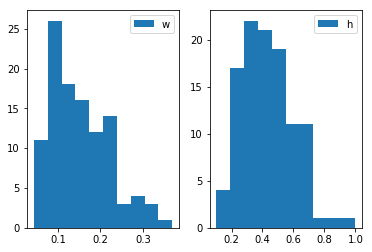

In [91]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.hist(w)
plt.legend(['w'])
plt.subplot(122)
plt.hist(h)
plt.legend(['h'])

In [98]:
#找到样本的4分位点
def find_seq(b,num=4):
    b = np.sort(b)
    N = b.shape[0]
    idx = np.array(np.linspace(0,N,num+1)).astype(int)-1
    return b[idx[1:]]
l = np.sqrt(w * h)
print(find_seq(l))
print(find_seq(w))
print(find_seq(h))

[ 0.17720574  0.23724939  0.30426919  0.54108638]
[ 0.09556162  0.13453832  0.19024843  0.36937141]
[ 0.31071246  0.40458742  0.52945453  0.99641377]


# calc mean and std

In [104]:
mean,std = cal_mean_std('./dataset/data/img512_512')

In [103]:
mean,std

(array([ 130.06304823,  129.96730104,  124.41076044]),
 array([ 61.04467501,  60.03631381,  60.7750983 ]))